## Gianluca Lombardi, Mattia Tarabolo

# Project: Unsupervised and supervised analysis of protein sequences

Typical questions:
- original analysis (if done)
- overcrowding problem in dim reduction
- how to choose number of clusters
- how the classifier we used works
- in general, not mathematical derivation


# Task 1: Import data and one-hot encoding


In [2]:
### Import data ###

# MSA_nat_with_annotation.faa -> natural labeled seqs (N = 1130)
# MSA_art.faa -> artificial labeled seqs (N = 1003)
# MSA_nat_no_annotation.faa -> natural unlabeled seqs (N = 6311)

# for record in SeqIO.parse("file.faa", "fasta"):
# record.description is a string "sequence_n funtional_true(false)"  (for labeled data)
# record.seq is the 96-aminoacids sequence, with 21 possible features
# record.name, record.id are "sequence_n"

# Each aa represented in one-hot encoding, ie as a 20-array ('-' corresponding to all 0s)
# L = 96 string feature -> N = 20*96 = 1920 binary variables
# binary label: functional_true -> 1, functional_false -> 0


import numpy as np
import matplotlib.pyplot as plt
import time

from Bio import SeqIO
from sklearn.preprocessing import LabelBinarizer

plt.rcParams.update({'font.size': 16})


# One-hot encoding fit for aminoacids
AAs_alphabet = list("ACDEFGHIKLMNPQRSTVWY")
lb = LabelBinarizer()
AAs_encoder = lb.fit(AAs_alphabet)

# Collect Data matrix and label vector for natural labeled data
X_nat = []
y_nat = []
for record in SeqIO.parse("MSA_nat_with_annotation.faa","fasta"):
    label = str(record.description).split()[1] # gives functional_false or functional_true
    y_nat.append(1 if label == "functional_true" else 0)
    prot_seq = list(str(record.seq))
    prot_seq = lb.transform(prot_seq).reshape(1,-1)
    X_nat.append(prot_seq)
X_nat = np.array(X_nat).reshape(len(X_nat),-1)
y_nat = np.array(y_nat)

# Collect Data matrix and label vector for artificial labeled data
X_art = []
y_art = []
for record in SeqIO.parse("MSA_art.faa","fasta"):
    label = str(record.description).split()[1] # gives functional_false or functional_true
    y_art.append(1 if label == "functional_true" else 0)
    prot_seq = list(str(record.seq))
    prot_seq = lb.transform(prot_seq).reshape(1,-1)
    X_art.append(prot_seq)
X_art = np.array(X_art).reshape(len(X_art),-1)
y_art = np.array(y_art)

# Collect Data matrix for natural unlabeled data
X_unlab = []
n_corrupted = 0     # some sequences contain unespected "X" labels
for record in SeqIO.parse("MSA_nat_no_annotation.faa","fasta"):
    prot_seq = list(str(record.seq))   
    if "X" in prot_seq:    
        n_corrupted += 1
        continue   
    prot_seq = lb.transform(prot_seq).reshape(1,-1)
    X_unlab.append(prot_seq)
X_unlab = np.array(X_unlab).reshape(len(X_unlab),-1)

print(X_nat.shape)
print(X_art.shape)
print(X_unlab.shape)
print("Number of corrupted unlabeled sequences = %d" %n_corrupted)

(1130, 1920)
(1003, 1920)
(6269, 1920)
Number of corrupted unlabeled sequences = 42


# Task 2: Principal components analysis

To do:
- compare distances in whole data and in the pca projection and see their correlation
- study heatmap to understand the number of points in a given region, especially when more crowded
- emphasise similarities and differences between natural and artificial data

PC1 variance fraction explained = 0.0434
PC2 variance fraction explained = 0.0330


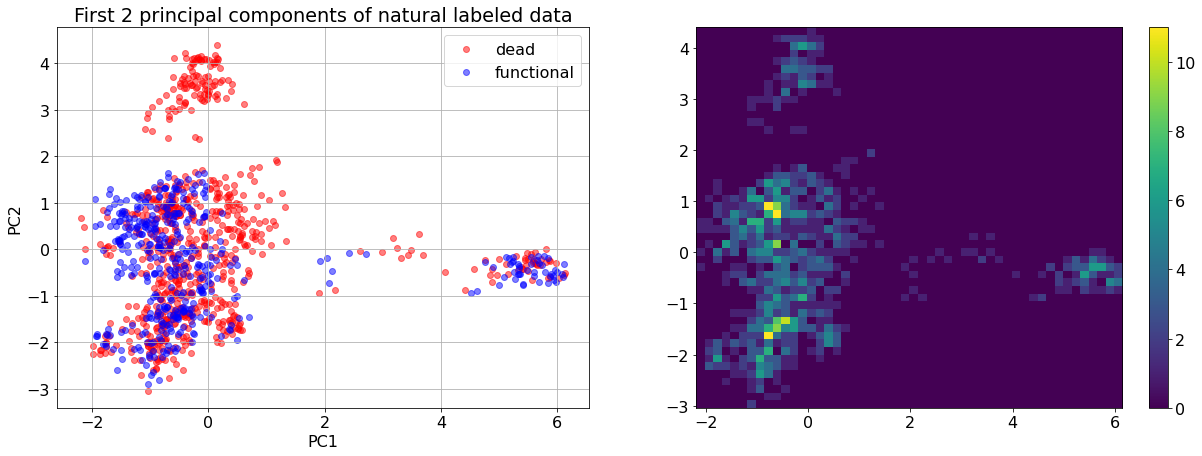

In [151]:
from sklearn import decomposition

# First 2 PCs of natural labeled data
pca = decomposition.PCA()
pca.fit(X_nat)
X_nat_pca = pca.transform(X_nat)
var_nat = pca.explained_variance_ratio_
print("PC1 variance fraction explained = %0.4f" %var_nat[0])
print("PC2 variance fraction explained = %0.4f" %var_nat[1])

fig, ax = plt.subplots(1,2, figsize = (21,7))
ax[0].scatter(X_nat_pca[y_nat==0,0],X_nat_pca[y_nat==0,1],c="r",alpha=0.5,label="dead")
ax[0].scatter(X_nat_pca[y_nat==1,0],X_nat_pca[y_nat==1,1],c="b",alpha=0.5,label="functional")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_title("First 2 principal components of natural labeled data")
ax[0].grid()
ax[0].legend()
#plt.gca().set_aspect("equal")

heatmap, xedges, yedges = np.histogram2d(X_nat_pca[:,0], X_nat_pca[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

pcm = ax[1].imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis')
fig.colorbar(pcm, ax=ax[1])

(-30.0, 1130.0)

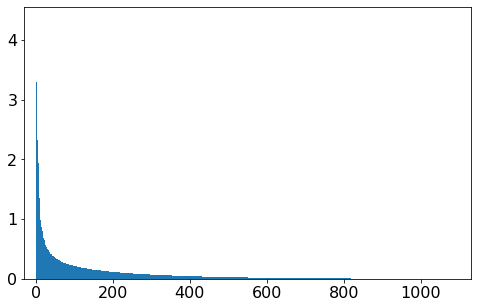

In [15]:
# Percentage of explained variance vs PCs

plt.figure(figsize=(8,5))
plt.bar(np.arange(0,len(var_nat)),var_nat*100, width=1)
plt.xlim(-30,len(var_nat))

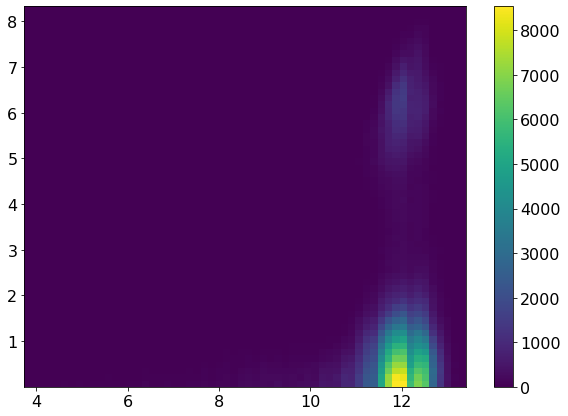

In [156]:
# Analysis of overcrowding phenomenon
import scipy.spatial.distance as dist
import random

dist_nat =dist.pdist(X_nat)
dist_nat_pca = dist.pdist(X_nat_pca[:,0:1])

#dist_nat_mean = dist_matrix_nat.mean()
#dist_nat_pca_mean = dist_matrix_nat_pca.mean()

#dist_nat_std = dist_matrix_nat.std()
#dist_nat_pca_std = dist_matrix_nat_pca.std()

#renormdist_matrix_nat = (dist_matrix_nat-dist_nat_mean)/dist_nat_std
#renormdist_matrix_nat_pca = (dist_matrix_nat_pca-dist_nat_pca_mean)/dist_nat_pca_std

fig, ax = plt.subplots(1, 1, figsize=(10,7))
heatmap, xedges, yedges = np.histogram2d(dist_nat, dist_nat_pca, bins=60)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

pcm = ax.imshow(heatmap.T, extent=extent, origin='lower')
fig.colorbar(pcm, ax=ax)

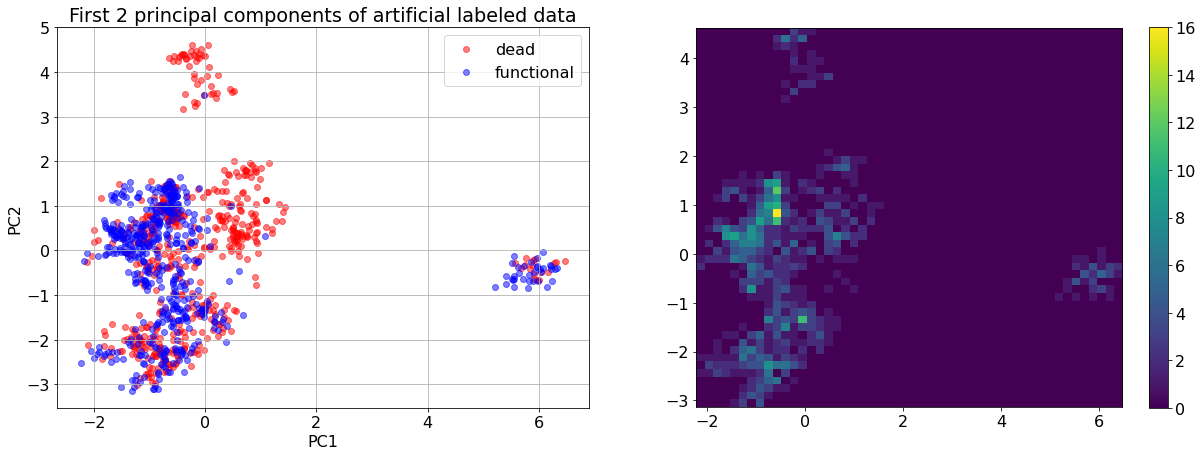

In [159]:
# Projection of artificial data on first 2 PCs of natural data
X_art_pca = pca.transform(X_art)

fig, ax = plt.subplots(1,2, figsize = (21,7))
ax[0].scatter(X_art_pca[y_art==0,0],X_art_pca[y_art==0,1],c="r",alpha=0.5,label="dead")
ax[0].scatter(X_art_pca[y_art==1,0],X_art_pca[y_art==1,1],c="b",alpha=0.5,label="functional")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_title("First 2 principal components of artificial labeled data")
ax[0].grid()
ax[0].legend()
#plt.gca().set_aspect("equal")

heatmap, xedges, yedges = np.histogram2d(X_art_pca[:,0], X_art_pca[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

pcm = ax[1].imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis')
fig.colorbar(pcm, ax=ax[1])

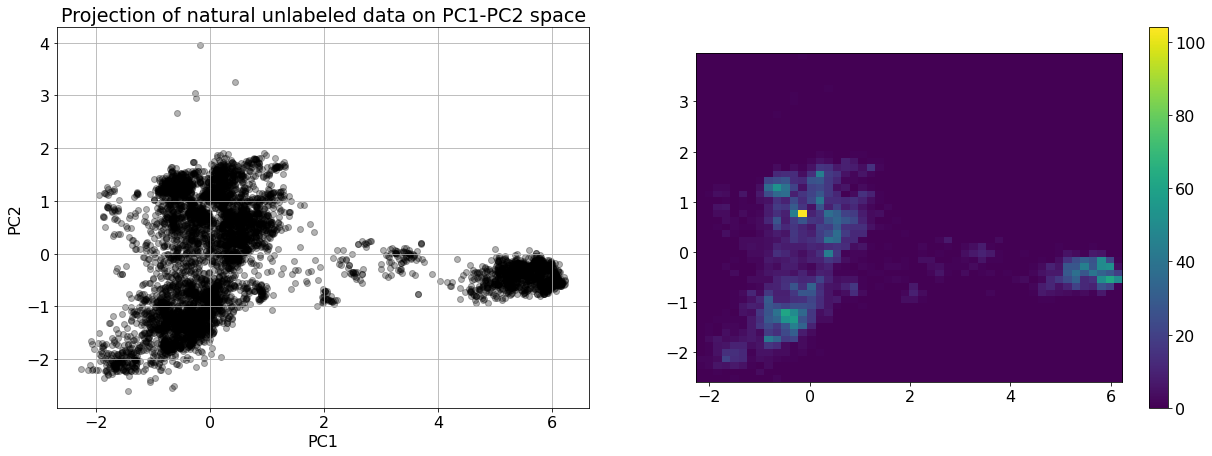

In [162]:
# Projection of unlabeled data on first 2 PCs of natural data
X_unlab_pca = pca.transform(X_unlab)

fig, ax = plt.subplots(1,2, figsize = (21,7))
ax[0].scatter(X_unlab_pca[:,0],X_unlab_pca[:,1],c="black",alpha=0.3)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[0].set_title("Projection of natural unlabeled data on PC1-PC2 space")
ax[0].grid()
#plt.gca().set_aspect("equal")

heatmap, xedges, yedges = np.histogram2d(X_unlab_pca[:,0], X_unlab_pca[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

pcm = ax[1].imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis')
fig.colorbar(pcm, ax=ax[1])

# Task 3: Unsupervised classification of data
 
## Clustering

 All analysis has to be done on the whole dataset, and then project on pca components
 Decide how many clusters to consider, depending on data structure
 staistical anlysis of clusters (number of data in each cluster, division functional/data, compare natural   artificial data, eg if a cluster contains only artificial data means that the generative model is not correct)
 
 Note generative model: too complicated

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(N_clusters=5).fit(X_nat)

# Task 4: Supervised analysis of data

## Logistic regression

### Checking accuracy as function of regularization factor for different optimization algorithms

finished computing 1/11 iterations
finished computing 2/11 iterations
finished computing 3/11 iterations
finished computing 4/11 iterations
finished computing 5/11 iterations
finished computing 6/11 iterations
finished computing 7/11 iterations
finished computing 8/11 iterations
finished computing 9/11 iterations
finished computing 10/11 iterations
finished computing 11/11 iterations


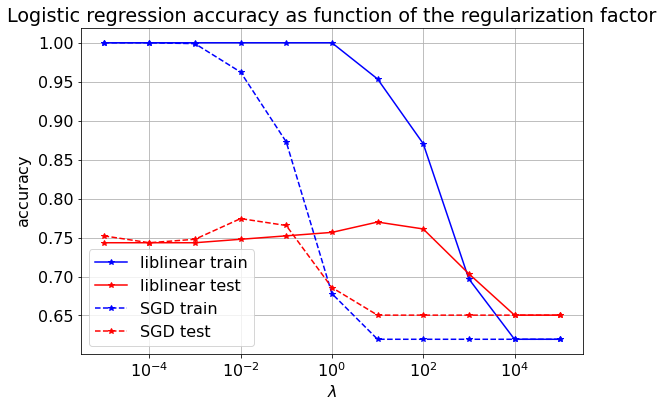

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Divide natural sequences in training and test set
train_to_test_ratio = 0.8
X_train,X_test,Y_train,Y_test = train_test_split(X_nat,y_nat,train_size=train_to_test_ratio)

# define regularisation parameter and preallocate accuracy data
lmbdas = np.logspace(-5,5,11)
train_accuracy = np.zeros(lmbdas.shape)
test_accuracy = np.zeros(lmbdas.shape)
train_accuracy_SGD = np.zeros(lmbdas.shape)
test_accuracy_SGD = np.zeros(lmbdas.shape)

# loop over regularisation factor
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg = linear_model.LogisticRegression(penalty='l2', C=1/lmbda, random_state=1,
                                             max_iter=1E3, tol=1E-5, solver='liblinear')
    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy for training and test set
    train_accuracy[i] = logreg.score(X_train,Y_train)
    test_accuracy[i] = logreg.score(X_test,Y_test)
    
    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy for training and test set
    train_accuracy_SGD[i] = logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i] = logreg_SGD.score(X_test,Y_test)
    
    # print("accuracy: train, test")
    # print("liblin: %0.4f, %0.4f" %(train_accuracy[i],test_accuracy[i]) )    
    # print("SGD: %0.4f, %0.4f" %(train_accuracy_SGD[i],test_accuracy_SGD[i]) )      
    print("finished computing %i/%i iterations" %(i+1,len(lmbdas)))


# plot accuracy against regularization strength
fig = plt.figure(figsize=(9,6))
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.title("Logistic regression accuracy as function of the regularization factor")
plt.grid()
plt.legend()
plt.show()

# Possible analysis:
# - use other classifiers (but liblinear is more appropriate for small datasets)
#       e.g.: lbfgs gives similar results, but is slower
#             sag, saga are very slow and do not converge
# - change regularization penalty (e.g. L1,l2 for liblinear, elastic net with different l1/l2 ratio for SGD)
# - change train/test ratio (but 0.8 is already a good compromise)
# - ...

### Predictions for unlabeled data for optimal accuracy

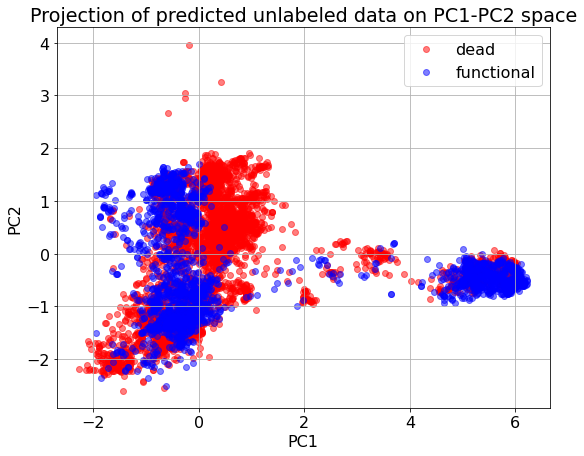

Number of predicted functional sequences = 2249/6269


In [9]:
# optimal lambda value = 10
logreg = linear_model.LogisticRegression(penalty='l2', C=0.1, random_state=1,
                                             max_iter=1E3, tol=1E-5, solver='liblinear')
logreg.fit(X_train,Y_train)
y_logreg = logreg.predict(X_unlab)
fig = plt.figure(figsize=(10,7))
plt.scatter(X_unlab_pca[y_logreg==0,0],X_unlab_pca[y_logreg==0,1],c="r",alpha=0.5,label="dead")
plt.scatter(X_unlab_pca[y_logreg==1,0],X_unlab_pca[y_logreg==1,1],c="b",alpha=0.5,label="functional")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection of predicted unlabeled data on PC1-PC2 space")
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

print("Number of predicted functional sequences = %i/6269" %sum(y_logreg))